# GM Model Norm


**Imports**

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
import seaborn as sns
import os
from matplotlib.widgets import Slider
import glob
import h5py
from datahelpers import DemandGridDataset
from model.models import VanillaConvLSTMFCNorm
from datetime import datetime
from datahelpers import standardize_grid
import json
from IPython.display import clear_output

def set_seed(seed: int):
    torch.manual_seed(seed)
    np.random.seed(seed)
set_seed(100)

**Dataloader**

In [2]:
SEGMENT_MIN=60
VERTICAL_LINES=4
HORIZONTAL_LINES=4
DATA_PATH="datasets/"
SUBSET = True
DATA_PREFIX="greenmobility_demand_prediction"
if SUBSET:
    DATA_PREFIX+='_CPH_SUB'
SEQ_LEN_SLICES=72
TEST=False
if TEST:
    DATA_PREFIX="test_"+DATA_PREFIX
    SEQ_LEN_SLICES=1

STANDARDIZE = False
STANDARDIZE_BATCHWISE = True
assert not (STANDARDIZE_BATCHWISE and STANDARDIZE)
RETURN_FEATURES = False


# For saving
MODEL_NAME="VanillaLSTMFCNorm_1_step_model"

In [3]:
# Params
batch_size = 1

# Load the dataset 
t1=datetime.now()
train_data = DemandGridDataset(DATA_PATH+DATA_PREFIX+"_train.csv", 
                         vertical_lines=VERTICAL_LINES, 
                         horizontal_lines=HORIZONTAL_LINES,
                         SEGMENT_MIN=SEGMENT_MIN,
                               SEQ_LEN_SLICES=SEQ_LEN_SLICES,
                              train=True,
                               return_features=RETURN_FEATURES,
                              standardize=STANDARDIZE,
                              standardize_batchwise=STANDARDIZE_BATCHWISE)
print("Traning loaded in: ",(datetime.now()-t1).seconds)

# Pass filters to validation and test
if STANDARDIZE:
    print("Enter")
    STANDARDIZE = (train_data.mean_grid, train_data.std_grid)

t2=datetime.now()
test_data = DemandGridDataset(DATA_PATH+DATA_PREFIX+"_test.csv", 
                         vertical_lines=VERTICAL_LINES, 
                         horizontal_lines=HORIZONTAL_LINES,
                         SEGMENT_MIN=SEGMENT_MIN,
                              SEQ_LEN_SLICES=SEQ_LEN_SLICES,
                              train=False,
                              return_features=RETURN_FEATURES, 
                              standardize=STANDARDIZE,
                             standardize_batchwise=STANDARDIZE_BATCHWISE)
print("Test loaded in: ",(datetime.now()-t2).seconds)
t2=datetime.now()
validation_data = DemandGridDataset(DATA_PATH+DATA_PREFIX+"_validation.csv", 
                         vertical_lines=VERTICAL_LINES, 
                         horizontal_lines=HORIZONTAL_LINES,
                         SEGMENT_MIN=SEGMENT_MIN,
                                    SEQ_LEN_SLICES=SEQ_LEN_SLICES,
                              train=False,
                                    return_features=RETURN_FEATURES, 
                                    standardize=STANDARDIZE,
                                   standardize_batchwise=STANDARDIZE_BATCHWISE)
print("Validation loaded in: ",(datetime.now()-t2).seconds)
print("Initializing loaders")
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)

validation_loader = torch.utils.data.DataLoader(dataset=validation_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)
print("Total time:",(datetime.now()-t1).seconds)

Traning loaded in:  36
Test loaded in:  5
Validation loaded in:  1
Initializing loaders
Total time: 44


In [4]:
print(len(train_loader))
print(len(test_loader))
print(len(validation_loader))

6418
922
268


## Model parameters

In [5]:
# Size of dim 0 of grid
input_dim = (HORIZONTAL_LINES)*(VERTICAL_LINES)
NF = 30
layer_dim = 1
output_dim = input_dim
in_chan=1

# Features added in FC layer - wd, dayofmonth, start, corona, h
features_fc = 7+31+24

## Model selections 

In [6]:
def tensor_from_features(features: dict) -> torch.tensor:
    temp = torch.cat((features['hour'].view(-1),
                      #features['time_since_corona'],
                      #features['time_since_launch'],
                      features['dayofweek'].view(-1),
                      features['day_of_month'].view(-1)))
    return temp

In [7]:
model = VanillaConvLSTMFCNorm(nf=NF, in_chan=1, grid_shape=(HORIZONTAL_LINES+1,VERTICAL_LINES+1))
model.double()
CUDA=False
if torch.cuda.is_available():
    print("Cuda")
    CUDA=True
    model.cuda()

In [8]:
# Verify correct layers
model.state_dict().keys()

odict_keys(['convlstm1.conv.weight', 'convlstm1.conv.bias', 'convlstm2.conv.weight', 'convlstm2.conv.bias', 'output_CNN.weight', 'output_CNN.bias', 'FC_CNN.weight', 'FC_CNN.bias'])

In [9]:
# Print model parameters
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

torch.Size([120, 31, 3, 3])
torch.Size([120])
torch.Size([120, 60, 3, 3])
torch.Size([120])
torch.Size([1, 30, 1, 3, 3])
torch.Size([1])
torch.Size([25, 25])
torch.Size([25])


## Loading State
for resuming traning etc.

In [10]:
LOAD_STATE = True
if LOAD_STATE:
    model.load_state_dict(torch.load('state_dict/5-5-Norm_FinalVanillaConvLSTMFCNorm_MSELoss', map_location='cpu'))

## Test of model
Assure it's working

In [11]:
for x in train_loader:
    break

In [12]:
x[0].unsqueeze(2).shape

torch.Size([1, 72, 1, 5, 5])

In [13]:
# Send a data through model to test it
model(x[0].unsqueeze(2)).shape

torch.Size([1, 1, 1, 5, 5])

## Loss

In [14]:
criterion = nn.MSELoss()

## Optimizer

In [15]:
learning_rate = 0.8e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

## Helperfunction for evaluation

In [16]:
def plot_tensor(tensor:torch.tensor):
    if len(tensor.shape)>2:
        # Select first element
        tensor=tensor[tuple([0]*(len(tensor.shape)-2))]
    plt.imshow(tensor.numpy().T,origin='lower', vmin=0, vmax=4)
    plt.colorbar()

## Traning

Below is the traning of the model

In [ ]:
set_seed(100)
SAVE_CHECKPOINTS = True

num_epochs = 20
itr = 0
# Save loss for plot
training_loss=[]
validation_loss=[]

t_L=train_loader

print("Start Iter")

# Status parameters
# Print every x iter
data_train_iter=400

global_steps=0
log_every=250

# Monitoring
t1=datetime.now()
t2=datetime.now()
for epoch in range(num_epochs):
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    model.eval()
    # For grid in validation set
    for i, (inputs, targets) in enumerate(validation_loader):
        # Add channel
        x = inputs.unsqueeze(2)
        y = targets.reshape(1,1,1,HORIZONTAL_LINES+1,VERTICAL_LINES+1)
        if CUDA:
            y = y.cuda()
            x = x.cuda()

        # Forward pass to get output/logits
        y_hat = model.forward(x, future_seq=1)
        
        # Calculate Loss: softmax --> cross entropy loss
        # outputs shifts channel one place left
        loss = criterion(y,y_hat)

        # Getting gradients w.r.t. parameters
        epoch_validation_loss += loss.cpu().detach().numpy()
        
    model.train()
    # For grid in traning set
    for i, (inputs, targets) in enumerate(train_loader):
        # Status updates
        if i%data_train_iter==0 and i>0: 
            print(f"Done with {int(i*100/len(t_L))}% of train in epoch {epoch} \nSeconds since start: {(datetime.now()-t1).seconds} \nSeconds since last status: {(datetime.now()-t2).seconds}")
            t2=datetime.now()
        # Add channel
        x = inputs.unsqueeze(2)
        y = targets.view(1,1,1,HORIZONTAL_LINES+1,VERTICAL_LINES+1)
        if CUDA:
            y = y.cuda()
            x = x.cuda()

        # Forward pass to get output/logits
        y_hat = model.forward(x, future_seq=1)
        
        # Calculate Loss: softmax --> cross entropy loss
        # outputs shifts channel one place left
        loss = criterion(y,y_hat)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        # Update loss
        epoch_training_loss += loss.cpu().detach().numpy()
        
        # Status updates
        # Print loss every x steps after 1
        if (global_steps % log_every == 0) and len(validation_loss)>0:
            #Report status
            print(f'Epoch: {epoch}, Global steps: {global_steps}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')
            print(loss)
            # Plot prediction
            plt.figure(figsize=(20,15))
            plt.subplot(2, 2, 1)
            plot_tensor(targets)
            plt.title("Target")
            plt.subplot(2, 2, 3)
            plt.title("Prediction")
            plot_tensor(y_hat.detach())
            plt.subplot(1, 2, 2)
            _epoch = np.arange(len(training_loss))
            plt.plot(_epoch, training_loss, 'r', label='Training loss',)
            plt.plot(_epoch, validation_loss, 'b', label='Validation loss')
            plt.title("Traning and validation loos")
            plt.ylim((0))
            plt.legend()
            plt.xlabel('Epoch'), plt.ylabel('VAL')
            plt.show()
            clear_output(wait=True)
                
        # Step taken
        global_steps+=1

    # Save
    if SAVE_CHECKPOINTS:
        model_name=f'./checkpoint_saves/5-5-Norm{type(model).__name__}_{type(criterion).__name__}_checkpoint_{datetime.now()}'
        # Send dict to memory
        torch.save(model.state_dict(), model_name)
        
    # Early breaking if validationloss increases 3 times
    if len(validation_loss)>3:
        if (validation_loss[-1]>=validation_loss[-2]) and (validation_loss[-1]>=validation_loss[-3]) and (validation_loss[-1]>=validation_loss[-4]):
            break
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(train_loader))
    validation_loss.append(epoch_validation_loss/len(validation_loader))

## Save model

In [68]:
if False:
    model_name=f'./state_dict/5-5-Norm_Final{type(model).__name__}_{type(criterion).__name__}'
    # Send dict to memory
    torch.save(model.state_dict(), model_name)

In [ ]:
training_loss

In [22]:
validation_loss

[1.272292640652749,
 1.1761042235185524,
 1.1755625186917544,
 1.175291265109579,
 1.0116927520865004,
 0.9468280502704508,
 0.9379783446403447,
 0.9427168668535917,
 0.9385746901802104,
 0.9334214055354658,
 0.9376726365509312,
 0.9357493255674607,
 1.0002624986188529]

## Saving stats

In [ ]:
train_eval={'validation_loss':validation_loss,
 'traning_loss':training_loss
}
file_name=f'{type(model).__name__}_{type(criterion).__name__}_train_eval_stats_{datetime.now()}.json'
with open(file_name, 'w') as outfile:
    json.dump(train_eval, outfile)
with open(file_name) as json_file:
    data = json.load(json_file)

## Visualizing learning

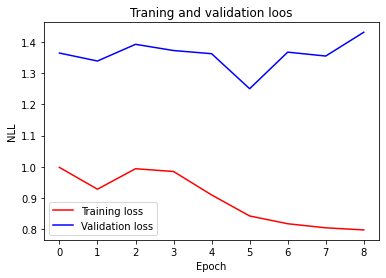

In [36]:
# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.title("Traning and validation loos")
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

## Single cell value prediction

In [17]:
ta_val=[]
out_val=[]
for i, (inputs, targets) in enumerate(test_loader):
    # Add channel
    x = inputs.unsqueeze(2)
    y = targets.reshape(1,1,1,HORIZONTAL_LINES+1,VERTICAL_LINES+1)
    if CUDA:
        y = y.cuda()
        x = x.cuda()

    # Forward pass to get output/logits
    y_hat = model.forward(x, future_seq=1)
    
    # Inverse standardization
    # Normal standardize
    '''
        ta_non_std.append(targets.detach().squeeze().numpy()[CELL])
        y_hat = standardize_grid(y_hat.detach().numpy().squeeze(),STANDARDIZE[0],STANDARDIZE[1], inverse=True)
        ta_v = standardize_grid(targets.detach().squeeze().numpy(),STANDARDIZE[0],STANDARDIZE[1], inverse=True)[CELL]
    '''
    # Batchwise
    _, __ , m, s = test_data.batchwise_std_inverse(i,return_params=True)
    y_hat = standardize_grid(y_hat.detach().numpy().squeeze(),m,s, inverse=True)
    ta_v = test_data.batchwise_std_inverse(i)[1].detach().squeeze().numpy()
    
    ta_val.append(ta_v)
    
    ou_v=y_hat
    out_val.append(ou_v)

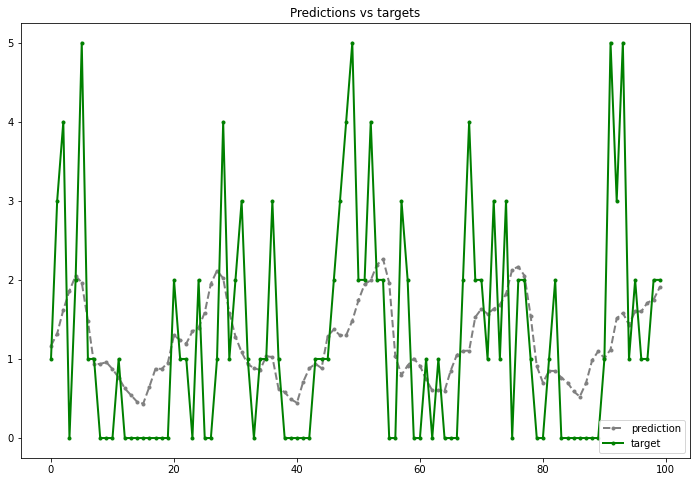

In [19]:
plt.figure(figsize=(12,8))
CELL =(4,2)

# Parameters
offset=0
data_points=100

# Don't touch
lim=offset+data_points
assert lim<len(out_val)
t=[i for i in range(len(out_val[offset:lim]))]
plt.plot(t, [x[CELL] for x in out_val][offset:lim], color='grey', marker='o', linestyle='dashed', linewidth=2, markersize=3, label='prediction')
plt.plot(t, [x[CELL] for x in ta_val][offset:lim], color='green', marker='o', linestyle='solid', linewidth=2, markersize=3, label='target')
plt.legend()
plt.title("Predictions vs targets")
plt.show()

## Calculate accuracy


In [21]:
import time
abs_= []
rel_ = [] 
def calculate_absolute(inp, lab):
    return np.sum(np.abs(lab-inp))
def calculate_relative(inp, lab, mean_grid):
    return np.sum(np.abs(lab-inp)/(1+mean_grid))

In [22]:
abs_v = np.mean(np.abs(list(map(calculate_absolute,out_val,ta_val))))
rel_v = np.mean(np.abs(list(map(calculate_relative,out_val,ta_val,train_data.mean_grid))))
print(abs_v,rel_v)

21.64110803586192 13.547214509789109


In [23]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

99441


In [18]:
# Save performance
with open('CLSTM_BN.npy', 'wb') as f:
    np.save(f, out_val)